<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Get Data

In [ ]:
#|eval: false
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", MissingPivotFunction)

In [ ]:
#|eval: false
result = query_api.query_data_frame(org=org, query=query)
result.columns

Index(['result', 'table', '_start', '_stop', '_time', '_value', '_field',
       '_measurement', 'device', 'sensor', 'units'],
      dtype='object')

In [ ]:
#|eval: false
result.shape

(4182, 11)

 result.to_csv(f'./Data/energy_info.csv', index=False) #save the data as a csv

In [ ]:
result.drop(['result', 'table', '_field', '_start', '_stop', '_measurement', 'units', 'device'], axis=1, inplace=True)

In [ ]:
#|eval: false
result.head()

,_time,_value,sensor
0,2023-03-02 00:00:00+00:00,12.888000,Aircon
1,2023-03-03 00:00:00+00:00,121.541007,Aircon
2,2023-03-04 00:00:00+00:00,222.993806,Aircon
3,2023-03-05 00:00:00+00:00,118.435757,Aircon
4,2023-03-06 00:00:00+00:00,238.721389,Aircon


In [ ]:
#|eval: false
result.columns

Index(['_time', '_value', 'sensor'], dtype='object')

## Energy in Wide Form

In [ ]:
#|eval: false
wide_df = result.pivot(index='_time', columns='sensor', values='_value')
# Reset the index to make 'id' a regular column
wide_df.reset_index(inplace=True)

wide_df.columns

Index(['_time', 'Aircon', 'Consumption', 'ConsumptionNet', 'Export', 'Fridge',
       'Garage', 'Hotwater', 'HouseBoardOutside', 'HouseBoardOutsideR',
       'HouseBoardR', 'Import', 'Lights', 'Net', 'OvenStove', 'Powerpoints',
       'Production', 'Unmonitored'],
      dtype='object', name='sensor')

In [ ]:
wide_df['_time'] = pd.to_datetime(wide_df['_time']).dt.tz_localize(None)
wide_df.drop(['Unmonitored', 'Consumption', 'ConsumptionNet'], axis = 1, inplace=True)
wide_df.rename(columns={'_time':'ds'}, inplace=True)
# Delete the last row
wide_df = wide_df.drop(wide_df.index[-1])

In [ ]:
wide_df_new = pd.DataFrame()
for column in wide_df.columns:
    wide_df_new[f'{column}'] = wide_df[f'{column}'].interpolate()

wide_df = pd.DataFrame(wide_df_new)
wide_df.columns

Index(['ds', 'Aircon', 'Export', 'Fridge', 'Garage', 'Hotwater',
       'HouseBoardOutside', 'HouseBoardOutsideR', 'HouseBoardR', 'Import',
       'Lights', 'Net', 'OvenStove', 'Powerpoints', 'Production'],
      dtype='object')

In [ ]:
wide_df.tail()

,ds,Aircon,Export,Fridge,Garage,Hotwater,HouseBoardOutside,HouseBoardOutsideR,HouseBoardR,Import,Lights,Net,OvenStove,Powerpoints,Production
240,2023-10-28,8.578005,180.242247,25.492343,24.017087,0.530865,999.775552,333.258545,366.408449,71.876417,80.009421,-108.365830,66.086281,176.392548,491.748285
241,2023-10-29,8.661682,806.610093,19.634587,2.731102,0.192283,530.312474,176.770805,201.397413,1.974071,60.108551,-804.636021,1.253300,103.451046,1017.375874
242,2023-10-30,8.603354,757.601472,27.081000,0.983716,0.183639,788.486015,262.828480,290.616882,3.378339,66.827993,-754.223132,1.356785,178.170521,1052.272015
243,2023-10-31,9.032917,803.841970,35.649472,11.163953,0.269313,901.165305,300.388379,319.795146,5.027126,67.972347,-798.814844,30.217549,166.649785,1142.661342
244,2023-11-01,8.743938,898.594991,30.389375,3.655479,0.189410,623.050504,207.683462,245.486118,2.309883,50.624125,-896.285107,0.213375,145.941312,1134.978184


In [ ]:
def data_scaler(df):
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler

    numeric_columns = df.select_dtypes(include=['number']).columns
        
    # Scale numeric columns
    df[numeric_columns] = MinMaxScaler().fit_transform(df[numeric_columns])

    return df

In [ ]:
def long_form(df_plot):
    return df_plot.melt('ds', var_name='unique_id', value_name='y')

def altair_plot(df_plot): 
    import altair as alt
    highlight = alt.selection_point(on='mouseover', fields=['unique_id'], bind='legend', nearest=True)

    base = alt.Chart(df_plot).encode(
        x='ds:T',
        y='y:Q',
        color='unique_id:N'
    )

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_params(
        highlight
    ).properties(
        width=1000
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3))
    )

    return points + lines

In [ ]:
wide_df = data_scaler(wide_df)
wide_df.tail()

,ds,Aircon,Export,Fridge,Garage,Hotwater,HouseBoardOutside,HouseBoardOutsideR,HouseBoardR,Import,Lights,Net,OvenStove,Powerpoints,Production
240,2023-10-28,0.000327,0.087269,0.054518,0.475787,0.000988,0.441317,0.270647,0.263152,0.098826,0.397064,0.702175,0.217335,0.451213,0.164710
241,2023-10-29,0.000459,0.390543,0.008991,0.049113,0.000167,0.155476,0.095349,0.096613,0.001842,0.287229,0.452268,0.003559,0.195780,0.385757
242,2023-10-30,0.000367,0.366814,0.066865,0.014087,0.000146,0.312670,0.191751,0.186659,0.003790,0.324314,0.470363,0.003900,0.457440,0.400433
243,2023-10-31,0.001045,0.389203,0.133461,0.218148,0.000354,0.381277,0.233826,0.216107,0.006078,0.330630,0.454358,0.099064,0.417095,0.438445
244,2023-11-01,0.000589,0.435080,0.092579,0.067642,0.000160,0.211942,0.129978,0.141110,0.002308,0.234883,0.419373,0.000130,0.344577,0.435214


In [ ]:
df = long_form(wide_df)
wide_df.rename(columns={'Lights': 'y'}, inplace=True)
wide_df['unique_id'] = 'Lights'
df.head()

,ds,unique_id,y
0,2023-03-02,Aircon,0.007134
1,2023-03-03,Aircon,0.178748
2,2023-03-04,Aircon,0.338990
3,2023-03-05,Aircon,0.173844
4,2023-03-06,Aircon,0.363831


## Weather data

In [ ]:
import pandas as pd
path = 'Data'
name = 'weather'

weather_df = pd.read_csv(f'{path}/{name}.csv')
weather_df.head()

,ds,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv
0,2023-01-01 00:00,21.6,0,12.6,126,1013.0,0.0,84,73,21.6,21.6,24.4,18.7,0,10.0,19.8,1.0
1,2023-01-01 01:00,21.3,0,11.9,133,1013.0,0.0,85,77,21.3,21.3,24.3,18.7,0,10.0,18.7,1.0
2,2023-01-01 02:00,21.1,0,11.2,140,1012.0,0.0,86,80,21.1,21.1,24.2,18.7,0,10.0,17.6,1.0
3,2023-01-01 03:00,20.8,0,10.4,147,1012.0,0.0,88,84,20.8,20.8,20.8,18.7,0,10.0,16.6,1.0
4,2023-01-01 04:00,21.0,0,10.6,144,1012.0,0.0,86,84,21.0,21.0,21.0,18.6,0,10.0,16.3,1.0


In [ ]:
weather_df = data_scaler(weather_df)

In [ ]:
def data_day_avg(weather_df):
    from tqdm.notebook import tqdm
    avg_df = pd.DataFrame()
    dates = pd.to_datetime(weather_df['ds']).dt.date.unique()
    
    for date in tqdm(dates):
        filtered_df = weather_df[pd.to_datetime(weather_df['ds']).dt.date == date]
        ds = filtered_df.pop('ds')

        filtered_df = pd.DataFrame(filtered_df.mean()).T
        filtered_df

        filtered_df.insert(0, 'ds', date)

        avg_df = pd.concat([avg_df, filtered_df], ignore_index=True)
    
    return avg_df

In [ ]:
weather_avg_df = data_day_avg(weather_df)

  0%|          | 0/344 [00:00<?, ?it/s]

In [ ]:
weather_avg_df['ds'] = pd.to_datetime(weather_avg_df['ds'])

In [ ]:
weather_avg_df

,ds,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv
0,2023-01-01,0.566503,0.583333,0.459098,0.345636,0.428728,0.000895,0.670886,0.583750,0.516791,0.595085,0.512881,0.778121,0.0,1.000000,0.434678,0.422619
1,2023-01-02,0.554902,0.583333,0.451453,0.396936,0.359649,0.001253,0.602848,0.409167,0.499005,0.584249,0.486067,0.725707,0.0,1.000000,0.434844,0.428571
2,2023-01-03,0.582516,0.583333,0.263889,0.415506,0.258772,0.000000,0.584916,0.287917,0.525746,0.610043,0.502366,0.738663,0.0,1.000000,0.283533,0.452381
3,2023-01-04,0.650490,0.583333,0.313073,0.382660,0.163377,0.000895,0.687764,0.196250,0.608582,0.673535,0.609621,0.866902,0.0,0.994792,0.305777,0.500000
4,2023-01-05,0.654575,0.583333,0.257518,0.506267,0.166667,0.026859,0.735232,0.700417,0.629726,0.677350,0.608701,0.911808,0.0,0.989583,0.288098,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,2023-12-06,0.580556,0.583333,0.254077,0.264740,0.558114,0.000000,0.608650,0.174583,0.519527,0.608364,0.515116,0.745878,0.0,1.000000,0.214558,0.470238
340,2023-12-07,0.605065,0.583333,0.266565,0.202066,0.565789,0.000000,0.582806,0.050000,0.543532,0.631258,0.533386,0.748233,0.0,1.000000,0.222693,0.476190
341,2023-12-08,0.618954,0.583333,0.349261,0.251625,0.575658,0.000018,0.626582,0.342083,0.561816,0.644078,0.555205,0.795200,0.0,1.000000,0.285940,0.476190
342,2023-12-09,0.612582,0.583333,0.362768,0.190460,0.544956,0.000107,0.577532,0.497500,0.564179,0.638584,0.539432,0.757509,0.0,1.000000,0.308267,0.428571


<Axes: title={'center': 'Lights'}>

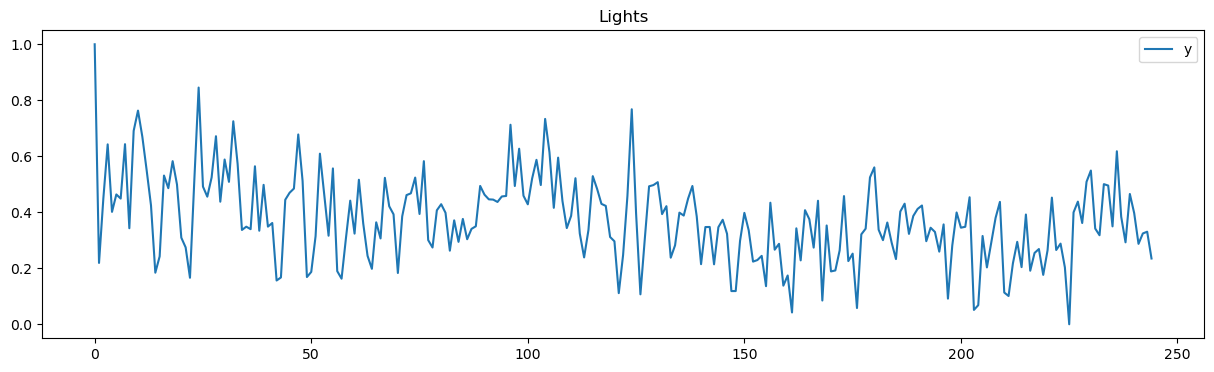

In [ ]:
#|eval: false
(
    wide_df[['y']].plot(title='Lights')
)

In [ ]:
#|eval: false
from statsforecast import StatsForecast

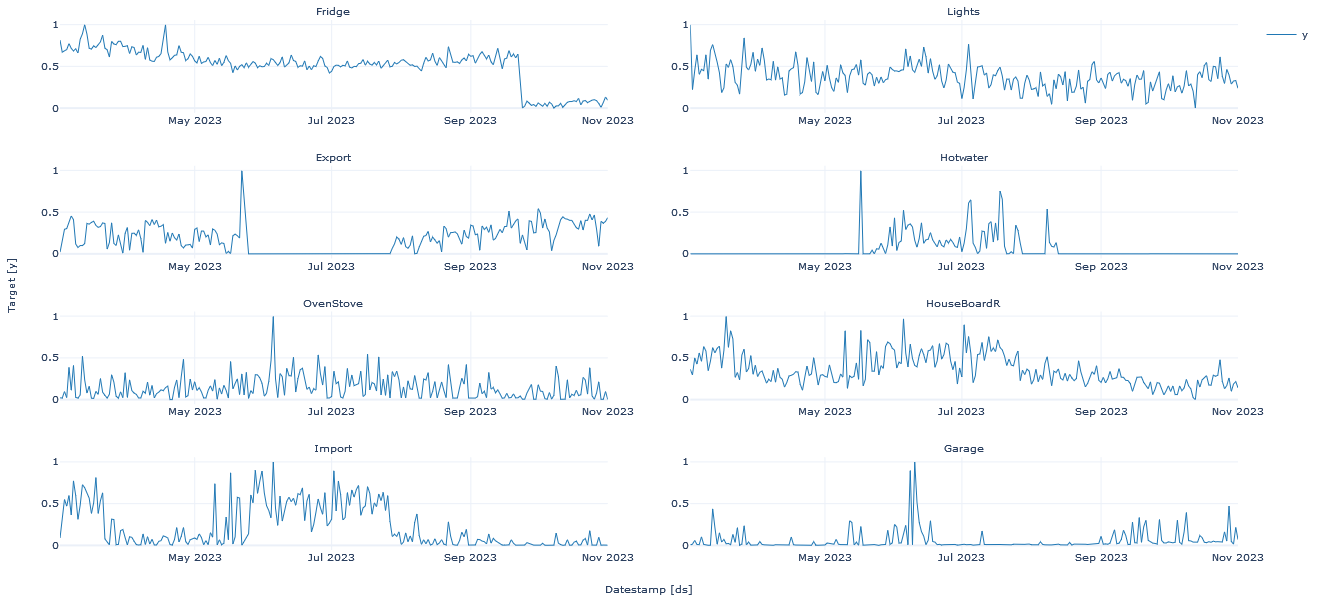

In [ ]:
#|eval: false
from pylab import rcParams
rcParams['figure.figsize'] = (15,4)
StatsForecast.plot(df, engine='plotly')

In [ ]:
wide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ds                  245 non-null    datetime64[ns]
 1   Aircon              245 non-null    float64       
 2   Export              245 non-null    float64       
 3   Fridge              245 non-null    float64       
 4   Garage              245 non-null    float64       
 5   Hotwater            245 non-null    float64       
 6   HouseBoardOutside   161 non-null    float64       
 7   HouseBoardOutsideR  245 non-null    float64       
 8   HouseBoardR         245 non-null    float64       
 9   Import              245 non-null    float64       
 10  y                   245 non-null    float64       
 11  Net                 245 non-null    float64       
 12  OvenStove           245 non-null    float64       
 13  Powerpoints         245 non-null    float64       

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         3430 non-null   datetime64[ns]
 1   unique_id  3430 non-null   object        
 2   y          3346 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 80.5+ KB


In [ ]:
weather_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              344 non-null    datetime64[ns]
 1   temp_c          344 non-null    float64       
 2   is_day          344 non-null    float64       
 3   wind_kph        344 non-null    float64       
 4   wind_degree     344 non-null    float64       
 5   pressure_mb     344 non-null    float64       
 6   precip_mm       344 non-null    float64       
 7   humidity        344 non-null    float64       
 8   cloud           344 non-null    float64       
 9   feelslike_c     344 non-null    float64       
 10  windchill_c     344 non-null    float64       
 11  heatindex_c     344 non-null    float64       
 12  dewpoint_c      344 non-null    float64       
 13  chance_of_rain  344 non-null    float64       
 14  vis_km          344 non-null    float64       
 15  gust_k

In [ ]:
date_range_start, date_range_end  = wide_df['ds'].min(), wide_df['ds'].max()
# Filter rows between the start and end dates
weather_avg_filtered_df = weather_avg_df[(weather_avg_df['ds'] >= date_range_start) & (weather_avg_df['ds'] <= date_range_end)]
weather_avg_filtered_df

,ds,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv
60,2023-03-02,0.644444,0.541667,0.294980,0.153784,0.344298,0.001056,0.675633,0.345417,0.609826,0.667888,0.594374,0.845112,0.0,1.0,0.250332,0.470238
61,2023-03-03,0.603268,0.541667,0.483563,0.386142,0.403509,0.002131,0.682489,0.579167,0.572388,0.629426,0.548107,0.821555,0.0,1.0,0.432022,0.380952
62,2023-03-04,0.561765,0.541667,0.574669,0.433612,0.425439,0.000161,0.604430,0.364583,0.509204,0.590659,0.491982,0.734982,0.0,1.0,0.485309,0.422619
63,2023-03-05,0.598039,0.541667,0.372324,0.350627,0.427632,0.000358,0.603903,0.401250,0.542537,0.624542,0.531677,0.761042,0.0,1.0,0.319804,0.428571
64,2023-03-06,0.629575,0.541667,0.313073,0.290854,0.417763,0.000358,0.608650,0.157500,0.568284,0.653999,0.557965,0.785925,0.0,1.0,0.263363,0.476190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2023-10-28,0.379575,0.541667,0.700051,0.446611,0.708333,0.000233,0.500000,0.389167,0.351741,0.414835,0.327681,0.497939,0.0,1.0,0.588811,0.345238
301,2023-10-29,0.382516,0.541667,0.383028,0.320682,0.656798,0.000125,0.524789,0.433750,0.347637,0.423230,0.329390,0.525324,0.0,1.0,0.328934,0.345238
302,2023-10-30,0.441340,0.583333,0.396152,0.435237,0.562500,0.000000,0.583861,0.181250,0.403483,0.478327,0.373686,0.611307,0.0,1.0,0.340139,0.416667
303,2023-10-31,0.550163,0.583333,0.489424,0.549559,0.442982,0.000000,0.570675,0.025417,0.492537,0.579976,0.467140,0.687132,0.0,1.0,0.470286,0.464286


In [ ]:
altair_plot(df)

alt.LayerChart(...)

In [ ]:
weather_avg_df_plot = long_form(weather_avg_filtered_df)
altair_plot(weather_avg_df_plot)

alt.LayerChart(...)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
wide_df["y"]

0      1.000000
1      0.219103
2      0.449558
3      0.642563
4      0.401555
         ...   
240    0.397064
241    0.287229
242    0.324314
243    0.330630
244    0.234883
Name: y, Length: 245, dtype: float64

In [ ]:
def augmented_dickey_fuller_test(series , column_name):
    from statsmodels.tsa.stattools import adfuller
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
augmented_dickey_fuller_test(wide_df["y"],'Ads')

Dickey-Fuller test results for columns: Ads
Test Statistic                  -3.110241
p-value                          0.025805
No Lags Used                    12.000000
Number of observations used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


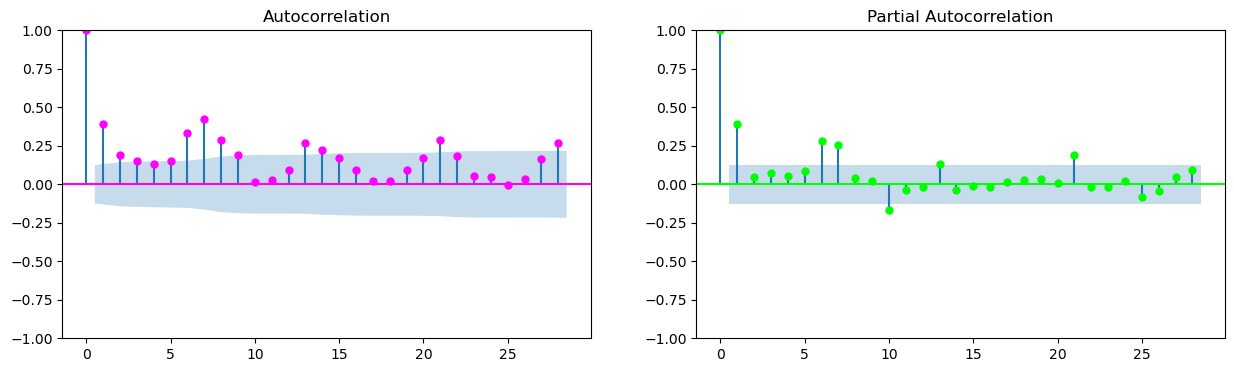

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(wide_df["y"],  lags=28, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(wide_df["y"],  lags=28, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

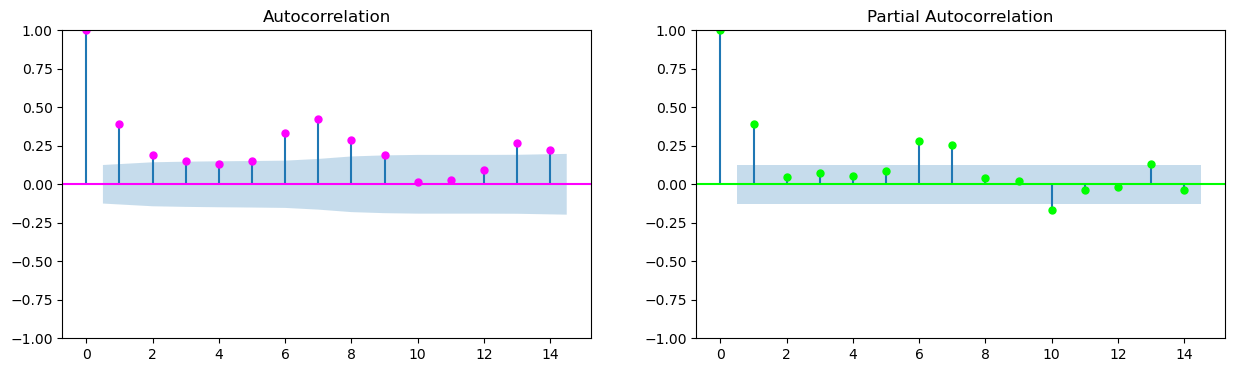

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(wide_df["y"],  lags=14, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(wide_df["y"],  lags=14, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

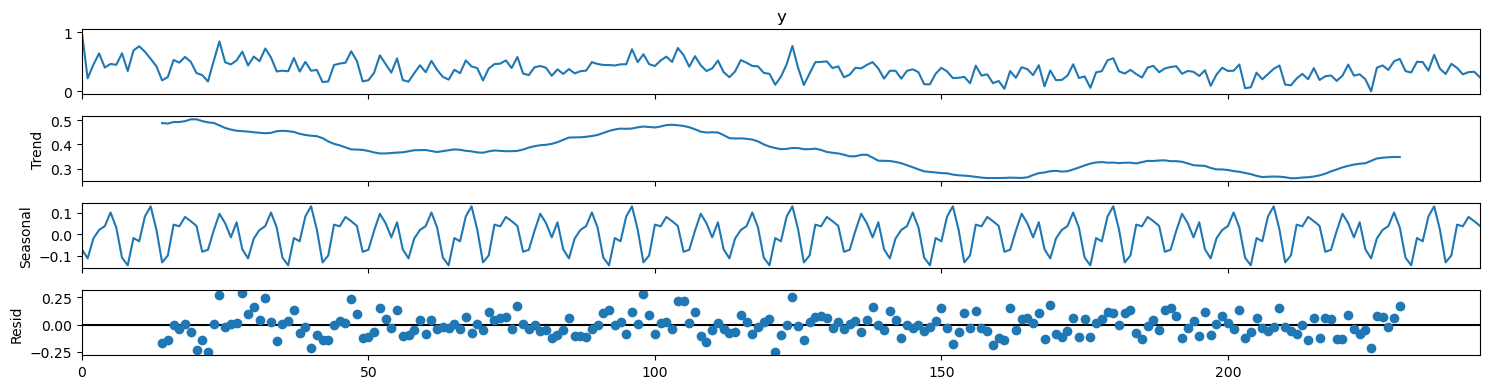

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(wide_df["y"], model = "additive", period=28)
a.plot();

## Designing Models

In [ ]:
weather_avg_filtered_df.head()

,ds,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv
60,2023-03-02,0.644444,0.541667,0.294980,0.153784,0.344298,0.001056,0.675633,0.345417,0.609826,0.667888,0.594374,0.845112,0.0,1.0,0.250332,0.470238
61,2023-03-03,0.603268,0.541667,0.483563,0.386142,0.403509,0.002131,0.682489,0.579167,0.572388,0.629426,0.548107,0.821555,0.0,1.0,0.432022,0.380952
62,2023-03-04,0.561765,0.541667,0.574669,0.433612,0.425439,0.000161,0.604430,0.364583,0.509204,0.590659,0.491982,0.734982,0.0,1.0,0.485309,0.422619
63,2023-03-05,0.598039,0.541667,0.372324,0.350627,0.427632,0.000358,0.603903,0.401250,0.542537,0.624542,0.531677,0.761042,0.0,1.0,0.319804,0.428571
64,2023-03-06,0.629575,0.541667,0.313073,0.290854,0.417763,0.000358,0.608650,0.157500,0.568284,0.653999,0.557965,0.785925,0.0,1.0,0.263363,0.476190


In [ ]:
wide_df = pd.merge(wide_df, weather_avg_filtered_df, on='ds', how='outer')

In [ ]:
wide_df.head()

,ds,Aircon,Export,Fridge,Garage,Hotwater,HouseBoardOutside,HouseBoardOutsideR,HouseBoardR,Import,...,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv
0,2023-03-02,0.007134,0.016595,0.814609,0.003794,0.000287,NaN,0.356702,0.364385,0.085067,...,0.675633,0.345417,0.609826,0.667888,0.594374,0.845112,0.0,1.0,0.250332,0.470238
1,2023-03-03,0.178748,0.165011,0.669709,0.015031,0.000143,NaN,0.292065,0.295309,0.296304,...,0.682489,0.579167,0.572388,0.629426,0.548107,0.821555,0.0,1.0,0.432022,0.380952
2,2023-03-04,0.338990,0.294620,0.686509,0.059559,0.000460,NaN,0.496691,0.501420,0.551547,...,0.604430,0.364583,0.509204,0.590659,0.491982,0.734982,0.0,1.0,0.485309,0.422619
3,2023-03-05,0.173844,0.302607,0.701288,0.009916,0.000256,NaN,0.419958,0.422212,0.467784,...,0.603903,0.401250,0.542537,0.624542,0.531677,0.761042,0.0,1.0,0.319804,0.428571
4,2023-03-06,0.363831,0.381220,0.773714,0.008798,0.002112,NaN,0.562640,0.561444,0.600856,...,0.608650,0.157500,0.568284,0.653999,0.557965,0.785925,0.0,1.0,0.263363,0.476190


In [ ]:
horizon = 10

train_size = len(wide_df) - horizon
train, test = wide_df[:train_size], wide_df[train_size:]


wide_df.shape, train.shape, test.shape

((245, 32), (235, 32), (10, 32))

In [ ]:
futr_df=weather_avg_filtered_df[train_size:]
futr_df['unique_id'] = 'Lights'

In [ ]:
futr_df.head()

,ds,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv,unique_id
295,2023-10-23,0.560784,0.500000,0.579256,0.550836,0.439693,0.000000,0.614979,0.075000,0.509328,0.589896,0.485279,0.734246,0.0,1.000000,0.512699,0.392857,Lights
296,2023-10-24,0.550490,0.541667,0.571738,0.437210,0.500000,0.000430,0.684599,0.150833,0.503483,0.580128,0.486593,0.771349,0.0,1.000000,0.495933,0.410714,Lights
297,2023-10-25,0.558660,0.541667,0.585117,0.546657,0.482456,0.000000,0.656646,0.073750,0.511070,0.588217,0.487119,0.759570,0.0,1.000000,0.513197,0.428571,Lights
298,2023-10-26,0.495261,0.541667,0.518349,0.551996,0.493421,0.005766,0.684072,0.593333,0.449627,0.528541,0.422581,0.725265,0.0,0.953125,0.448705,0.363095,Lights
299,2023-10-27,0.309314,0.541667,0.621814,0.516481,0.633772,0.008792,0.767932,0.862500,0.289552,0.355311,0.249211,0.616166,0.0,0.994792,0.573373,0.232143,Lights


In [ ]:
from neuralforecast import models
models.__all__

['RNN',
 'GRU',
 'LSTM',
 'TCN',
 'DeepAR',
 'DilatedRNN',
 'MLP',
 'NHITS',
 'NBEATS',
 'NBEATSx',
 'TFT',
 'VanillaTransformer',
 'Informer',
 'Autoformer',
 'PatchTST',
 'FEDformer',
 'StemGNN',
 'HINT',
 'TimesNet']

In [ ]:
from ray import tune

from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoMLP
from neuralforecast.models import *

In [ ]:
model_list = [RNN,
 GRU,
 LSTM,
 TCN,
 #DeepAR,  # not good
 DilatedRNN,
 MLP,
 NHITS,
 NBEATS,
 NBEATSx,
 #TFT, # too much GPU
 #VanillaTransformer, # not good
 #Informer,
 #Autoformer,
 #PatchTST, # too much GPU
 #FEDformer, #taken too long
 #StemGNN, #need n_series
 #HINT, #need n_series
 #TimesNet # takes too long
             ]

In [ ]:
wide_df.columns

Index(['ds', 'Aircon', 'Export', 'Fridge', 'Garage', 'Hotwater',
       'HouseBoardOutside', 'HouseBoardOutsideR', 'HouseBoardR', 'Import', 'y',
       'Net', 'OvenStove', 'Powerpoints', 'Production', 'unique_id', 'temp_c',
       'is_day', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm',
       'humidity', 'cloud', 'feelslike_c', 'windchill_c', 'heatindex_c',
       'dewpoint_c', 'chance_of_rain', 'vis_km', 'gust_kph', 'uv'],
      dtype='object')

In [ ]:
models = [model(input_size=5 * horizon,
                h=horizon,
                max_steps=2000,
                hist_exog_list =['Export',
                                ],
                futr_exog_list = ['temp_c', 'is_day', 'wind_kph', 'wind_degree',
                    'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c',
                    'windchill_c', 'heatindex_c', 'dewpoint_c', 'chance_of_rain',
                    'vis_km', 'gust_kph', 'uv']
               ) for model in model_list]
models

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


[RNN, GRU, LSTM, TCN, DilatedRNN, MLP, NHITS, NBEATS, NBEATSx]

In [ ]:
nf = NeuralForecast(
    models=models, 
    freq='D')

In [ ]:
train.columns

Index(['ds', 'Aircon', 'Export', 'Fridge', 'Garage', 'Hotwater',
       'HouseBoardOutside', 'HouseBoardOutsideR', 'HouseBoardR', 'Import', 'y',
       'Net', 'OvenStove', 'Powerpoints', 'Production', 'unique_id', 'temp_c',
       'is_day', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm',
       'humidity', 'cloud', 'feelslike_c', 'windchill_c', 'heatindex_c',
       'dewpoint_c', 'chance_of_rain', 'vis_km', 'gust_kph', 'uv'],
      dtype='object')

In [ ]:
nf.fit(df=train)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
futr_df.head()

,ds,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,windchill_c,heatindex_c,dewpoint_c,chance_of_rain,vis_km,gust_kph,uv,unique_id
295,2023-10-23,0.560784,0.500000,0.579256,0.550836,0.439693,0.000000,0.614979,0.075000,0.509328,0.589896,0.485279,0.734246,0.0,1.000000,0.512699,0.392857,Lights
296,2023-10-24,0.550490,0.541667,0.571738,0.437210,0.500000,0.000430,0.684599,0.150833,0.503483,0.580128,0.486593,0.771349,0.0,1.000000,0.495933,0.410714,Lights
297,2023-10-25,0.558660,0.541667,0.585117,0.546657,0.482456,0.000000,0.656646,0.073750,0.511070,0.588217,0.487119,0.759570,0.0,1.000000,0.513197,0.428571,Lights
298,2023-10-26,0.495261,0.541667,0.518349,0.551996,0.493421,0.005766,0.684072,0.593333,0.449627,0.528541,0.422581,0.725265,0.0,0.953125,0.448705,0.363095,Lights
299,2023-10-27,0.309314,0.541667,0.621814,0.516481,0.633772,0.008792,0.767932,0.862500,0.289552,0.355311,0.249211,0.616166,0.0,0.994792,0.573373,0.232143,Lights


In [ ]:
consumption_predict = nf.predict(futr_df=futr_df).reset_index()
consumption_predict.head()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,RNN,GRU,LSTM,TCN,DilatedRNN,MLP,NHITS,NBEATS,NBEATSx
0,Lights,2023-10-23,0.507807,0.379466,0.478897,0.511510,0.563464,0.161172,0.416092,0.450695,0.442487
1,Lights,2023-10-24,0.393286,0.316233,0.490113,0.475892,0.473403,0.305529,0.480687,0.536951,0.494100
2,Lights,2023-10-25,0.274335,0.229077,0.081534,0.302572,0.333799,0.245025,0.473535,0.502184,0.387711
3,Lights,2023-10-26,0.301236,0.221772,0.089306,0.287488,0.292562,0.086765,0.323140,0.422453,0.293017
4,Lights,2023-10-27,0.127637,0.043374,0.074683,0.128003,0.258646,0.326311,0.473880,0.557035,0.491085


In [ ]:
consumption_predict.drop('unique_id', axis=1, inplace=True)

In [ ]:
just_production = df[df['unique_id'] == 'Lights']

In [ ]:
consumption_predict_plot = long_form(consumption_predict)
consumption_predict_plot = pd.concat([consumption_predict_plot, just_production.tail(50)]
                                     , ignore_index=True)
consumption_predict_plot

,ds,unique_id,y
0,2023-10-23,RNN,0.435813
1,2023-10-24,RNN,0.471173
2,2023-10-25,RNN,0.488459
3,2023-10-26,RNN,0.456378
4,2023-10-27,RNN,0.370659
...,...,...,...
135,2023-10-28,Lights,0.397064
136,2023-10-29,Lights,0.287229
137,2023-10-30,Lights,0.324314
138,2023-10-31,Lights,0.330630


In [ ]:
altair_plot(consumption_predict_plot)

alt.LayerChart(...)

## Performance

In [ ]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [ ]:
consumption_predict.info(), consumption_predict.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          10 non-null     datetime64[ns]
 1   RNN         10 non-null     float64       
 2   GRU         10 non-null     float64       
 3   LSTM        10 non-null     float64       
 4   TCN         10 non-null     float64       
 5   DilatedRNN  10 non-null     float64       
 6   MLP         10 non-null     float64       
 7   NHITS       10 non-null     float64       
 8   NBEATS      10 non-null     float64       
 9   NBEATSx     10 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 932.0 bytes


(None,
 Index(['ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP', 'NHITS',
        'NBEATS', 'NBEATSx'],
       dtype='object'))

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred):
    #y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    print(y_pred.columns)
    for i, model in enumerate(y_pred.columns):
        if i < 2: continue
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                    y_pred[model].values, 
                                                    y_hist['y'].values, seasonality=12)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_pred[model].values)
    return pd.DataFrame(evaluation)

In [ ]:
score = evaluate_performace(train, test, consumption_predict)
score.style.background_gradient(cmap ='YlGn', axis = 1,low=0.5, high=0.6)

Index(['ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP', 'NHITS',
       'NBEATS', 'NBEATSx'],
      dtype='object')


,GRU,LSTM,TCN,DilatedRNN,MLP,NHITS,NBEATS,NBEATSx
mase,0.371110,0.373379,0.376333,0.386538,0.426027,0.392198,0.419957,0.429512
mae,0.048412,0.048708,0.049094,0.050425,0.055577,0.051163,0.054785,0.056031
mape,259.057162,160.017654,375.530638,807.648400,1278.895162,616.177544,1099.112504,2281.618162
rmse,0.086880,0.088143,0.087256,0.085695,0.088678,0.088601,0.090735,0.086129
smape,138.050393,137.216017,143.938382,171.561234,187.530805,164.534808,173.732277,187.285272


<Axes: >

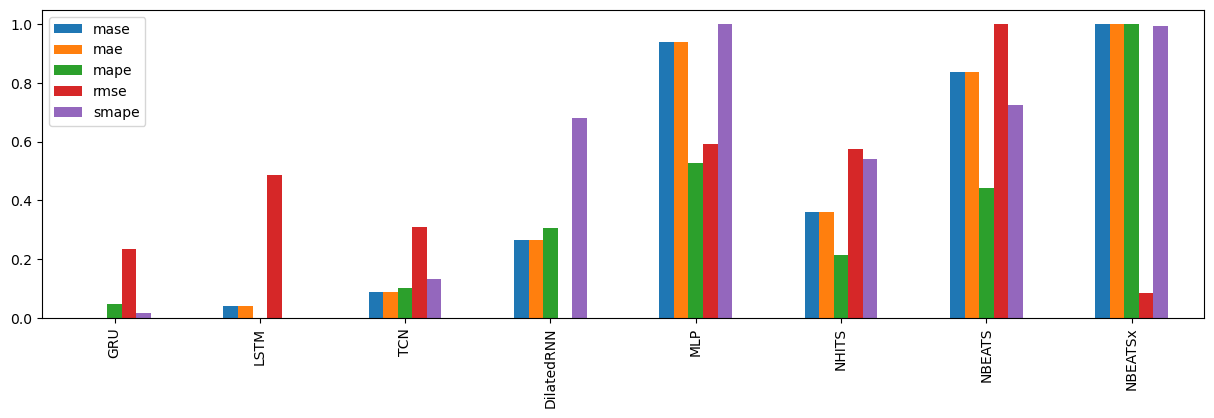

In [ ]:
score = data_scaler(score.T)
score.plot(kind='bar', legend=True)

In [ ]:
results = evaluate_performace(train, test, consumption_predict)
results.to_csv('Data/Neutral_results6.csv')

Index(['ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP', 'NHITS',
       'NBEATS', 'NBEATSx'],
      dtype='object')


## Cross_Validate

In [ ]:
cv_df = nf.cross_validation(train,
                            n_windows=3,
                            step_size= 1,
                           )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
cv_df.columns

Index(['unique_id', 'ds', 'cutoff', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN',
       'MLP', 'NHITS', 'NBEATS', 'NBEATSx', 'y', 'Export', 'Fridge', 'Garage',
       'Hotwater', 'HouseBoardOutside', 'HouseBoardOutsideR', 'HouseBoardR',
       'Import', 'Lights', 'Net', 'OvenStove', 'Powerpoints', 'Production',
       'temp_c', 'is_day', 'wind_kph', 'wind_degree', 'pressure_mb',
       'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'windchill_c',
       'heatindex_c', 'dewpoint_c', 'chance_of_rain', 'vis_km', 'gust_kph',
       'uv'],
      dtype='object')

In [ ]:
cv_df.drop('cutoff', axis=1, inplace=True)
cv_df.drop('unique_id', axis=1, inplace=True)

In [ ]:
cv_df['RNN'].head()

0    0.003673
1    0.003411
2    0.005272
3    0.004834
4    0.003371
Name: RNN, dtype: float32

In [ ]:
consumption_predict.columns

Index(['ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP', 'NHITS',
       'NBEATS', 'NBEATSx'],
      dtype='object')

In [ ]:
cv_df_filter = cv_df[consumption_predict.columns]
cv_df_filter.head()

,ds,RNN,GRU,LSTM,TCN,DilatedRNN,MLP,NHITS,NBEATS,NBEATSx
0,2023-10-11,0.003673,0.005021,0.004987,0.005792,0.005489,-0.009889,-0.003473,-0.001256,-0.030136
1,2023-10-12,0.003411,0.005343,0.005253,0.005539,0.006155,-0.005851,-0.002714,0.004471,-0.001906
2,2023-10-13,0.005272,0.004845,0.005999,0.007143,0.004875,-0.002195,-0.004884,-0.004693,-0.008124
3,2023-10-14,0.004834,0.004222,0.005454,0.007220,0.005831,-0.001914,-0.004632,0.003145,0.017054
4,2023-10-15,0.003371,0.004710,0.005032,0.006623,0.005268,-0.005891,-0.005599,0.005866,-0.004327


In [ ]:
cv_df_plot = long_form(cv_df_filter)

In [ ]:
cv_df_plot.head()

,ds,unique_id,y
0,2023-10-11,RNN,0.003673
1,2023-10-12,RNN,0.003411
2,2023-10-13,RNN,0.005272
3,2023-10-14,RNN,0.004834
4,2023-10-15,RNN,0.003371


In [ ]:
altair_plot(cv_df_plot)

alt.LayerChart(...)